# Project 4: Predicting Indeed.com Data Science Job Listing Quality

#### Problem Statement 

The goal of this project is to design a model that can decide if a "data science" job listing on indeed.com is a "good" job or "bad" job. A good job will be defined by if the job's salary is above the median for the data set, a bad job will have a salary below the median. The core of this model will be logicist regression, which will use words in the "summary" and "title" columns to predict if the job is above or below median salary. The accuracy of this model will be determined by reducing its false positive and false negative rate. 

#### Exploritory Data Analysis 

In [1]:
#loading data 
import pandas as pd
file_name = '~/dsi/DSI_Workspace/project-04/assets/indeed-scraped-job-postings.csv'
df = pd.read_csv(file_name)

In [2]:
df.head()

,city,company,salary,summary,title,parsed_salary
0,Denver,Department Of The Interior,"$76,341 - $99,243 a year","Would you like to join the more than 10,000 sc...","Statistician, GS-1350-12 (DEU-PERM-DS)",87792.0
1,Denver,Department Of The Interior,"$71,012 - $99,243 a year",Investigate potential uses of geospatial data ...,Interdisciplinary Cartographer/Geographer - GS...,85127.5
2,Denver,Mental Health Center of Denver,"$70,000 - $80,000 a year",Advise the Data Developer with regard to creat...,Financial Data Scientist,75000.0
3,Denver,Denver Public Schools,"$62,712 - $75,255 a year",Portal managers on student outcome data report...,SENIOR RESEARCH ANALYST,68983.5
4,Denver,University of Colorado,"$25,000 - $29,000 a year",Experience entering and manipulating data in a...,Animal Care I,27000.0


In [3]:
df.shape

(413, 6)

The data set has 413 jobs, with city, salary, summary, title and parsed salary as its features. parsed_salary is the average yearly salary for the job from the salary range given in the salary column. Thus, parased_salary will be used to make the target vector.

The approach that seems most proper to this problem is to use city, common words in summary and title columns as the feature set to predict our target vector, "good" or bad "job".

Given the small size of this data set, feature selection should be limited to avoid adding in too much dimensionality to the model. 

#### Feature Engineering 

In [4]:
#first deleting company,salary from data set
del df['company']
del df['salary']

In [5]:
#drop nans
df = df.dropna()

In [6]:
#find median parsed_salary
import numpy as np
median_salary = np.median(df['parsed_salary'])
median_salary

100000.0

The median salary in the listing is 100,000... very good! I am glad I decided to transition to this field. Now to create the feature matrix, 1 being above 100k, 2 being below.

In [7]:
def create_target(salary):
    if salary >= median_salary:
        return 1
    else:
        return 0

In [8]:
df['job_quality'] = df['parsed_salary'].apply(create_target)

In [9]:
#check to see if function worked
df.head(20)

,city,summary,title,parsed_salary,job_quality
0,Denver,"Would you like to join the more than 10,000 sc...","Statistician, GS-1350-12 (DEU-PERM-DS)",87792.0,0
1,Denver,Investigate potential uses of geospatial data ...,Interdisciplinary Cartographer/Geographer - GS...,85127.5,0
2,Denver,Advise the Data Developer with regard to creat...,Financial Data Scientist,75000.0,0
3,Denver,Portal managers on student outcome data report...,SENIOR RESEARCH ANALYST,68983.5,0
4,Denver,Experience entering and manipulating data in a...,Animal Care I,27000.0,0
5,Denver,Functions largely independently but reports to...,Assistant Research Scientist - RADARS,93645.0,0
6,Denver,"Assist research director, assistant research d...",Statistical Research Specialist,66654.0,0
7,Denver,"Assist research director, assistant research d...",Statistical Research Scientist - RADARS,66654.0,0
8,Denver,And effective working relationships with physi...,Regulatory & Compliance Manager,77500.0,0
9,Denver,We are looking for a Software Engineer/Data Sc...,Software Engineer/Data Scientist,130000.0,1


Now we can create the feature matrix, first we will create dummy variables for each city.

In [10]:
#first build dummy variables for each city
df = pd.get_dummies(df,columns=['city'])

Next we can find the 10 most fequently used words in the summary column. I am choosing 10 to avoid dimensionality. SKlearn's CountVecotrizer can accomplish this, eliminating "stop words". 

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
words = CountVectorizer(max_features=10,stop_words='english')
words.fit_transform(df.summary)
words.vocabulary_

{u'analysis': 0,
 u'analytics': 1,
 u'data': 2,
 u'experience': 3,
 u'looking': 4,
 u'research': 5,
 u'scientist': 6,
 u'scientists': 7,
 u'senior': 8,
 u'team': 9}

Check to see if word is in summary, 1 if it is, 0 if it isn't, compile into dictionary of lists. Because of a decoding error when doing the traditional method, I had to do this by hand in a loop, using the str.decode function. I am not sure why traditional strings were messed up in the data set. Anyway, this gets past this error and gets a dictionary of dummy variables that I can merge with the data frame.

In [12]:
words_summary = {}
for word in words.vocabulary_.keys():
    words_summary['summary_' + word] = []
    for summary in df.summary:
        summary = summary.decode(encoding='UTF-8',errors='strict')
        if word in summary.lower():
            words_summary['summary_'+ word].append(1)
        else:
            words_summary['summary_'+ word].append(0)

words_summary = pd.DataFrame(words_summary)
df_with_summaries = pd.concat([df,words_summary],axis=1)
del df_with_summaries['summary']

In [13]:
df_with_summaries.head()

,title,parsed_salary,job_quality,city_Atlanta,city_Austin,city_Boston,city_Chicago,city_Dallas,city_Denver,city_Houston,...,summary_analysis,summary_analytics,summary_data,summary_experience,summary_looking,summary_research,summary_scientist,summary_scientists,summary_senior,summary_team
0,"Statistician, GS-1350-12 (DEU-PERM-DS)",87792.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,Interdisciplinary Cartographer/Geographer - GS...,85127.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Financial Data Scientist,75000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SENIOR RESEARCH ANALYST,68983.5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,Animal Care I,27000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0


Now finding the five most frequently used words in title and adding them to features just like summary

In [14]:
df_with_summaries = df_with_summaries.dropna()

In [15]:
new_words = CountVectorizer(max_features=5,stop_words='english')
new_words.fit_transform(df_with_summaries.title)
new_words.vocabulary_

{u'analyst': 0, u'data': 1, u'research': 2, u'scientist': 3, u'senior': 4}

In [16]:
words_title = {}
for word in new_words.vocabulary_.keys():
    words_title['title_' + word] = []
    for title in df_with_summaries.title:
        title = title.decode(encoding='UTF-8',errors='strict')
        if word in title.lower():
            words_title['title_'+ word].append(1)
        else:
            words_title['title_'+ word].append(0)

words_title = pd.DataFrame(words_title)
df_with_summaries_titles = pd.concat([df_with_summaries,words_title],axis=1)
del df_with_summaries_titles['title']

In [17]:
df_with_summaries_titles = df_with_summaries_titles.dropna()

Now that feature engineering is complete, can make final target and feature matrix to get ready for feature selection

In [18]:
y = df_with_summaries_titles['job_quality']
del df_with_summaries_titles['job_quality']
del df_with_summaries_titles['parsed_salary']
X = df_with_summaries_titles

#### Feature Selection and Modeling

First, we need to import all the things for modeling, scaling isn't needed since everything is catagorical variables

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

Splitting training set and testing set

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0,test_size = 0.30)

Using RFE (which estimates the coefficents of a linear model, perfect for logistic regression) to select the  best parameters.

In [21]:
classifier = LogisticRegression()
rfe = RFE(classifier)

Apply grid search to RFE, going over # of paramters to select to find optimal paramaters.

In [22]:
num_of_Features = np.linspace(1,33,33)#optimal number of features, feature set has 33

In [23]:
parameters = {'n_features_to_select':num_of_Features}
logistic_RFE_grid = GridSearchCV(rfe,parameters)

In [24]:
logistic_RFE_grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=None, step=1, verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_features_to_select': array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [25]:
print "training score", logistic_RFE_grid.score(X_train,y_train)
print "test score", logistic_RFE_grid.score(X_test,y_test)

training score 0.733576642336
test score 0.677966101695


A training score of about 73% accuracy, and a test score of about 68% accuracy. I am satisfied with these scores given the entire data set is so small. I think this validates my approach as a sensible one.

#### Model Validation

While the test score certainly validates its accuracy, we still want to look at the the confusion matrix/ROC curve to further validate the model's accuracy. Below is a plot of the contigency matrix

In [28]:
y_pred = logistic_RFE_grid.predict(X_test)

In [29]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test,y_pred)

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [37]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.6         0.4       ]
 [ 0.25396825  0.74603175]]


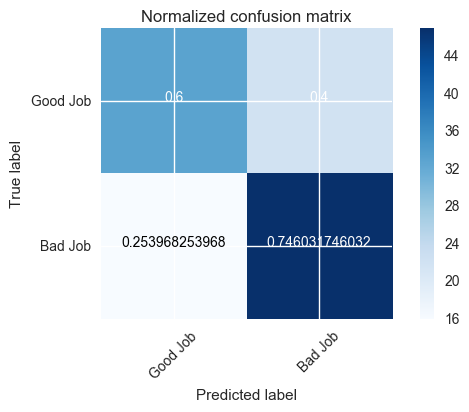

In [38]:
plt.figure()
plot_confusion_matrix(confusion, classes=['Good Job','Bad Job'], normalize=True,
                      title='Normalized confusion matrix')


Digging a bit deeper, The model makes a "True" good job prediction 60% of the time, and a "False" good job prediction 40% of the time. Also, the model makes a "false" bad job prediction 25.3% of the time and a "True" Bad Job prediction 74.6% of the time. I think these results are acceptable, as the data set is so small it is hard to not to False Positives and False Negatives. Since this is a binary classifier, our baseline (without the logistic regression) accuracy would expect to be 50%, like a coin-flip. This model predicts Good Jobs and Bad jobs significantly better, despite the small data set.

Now we plot the roc curve

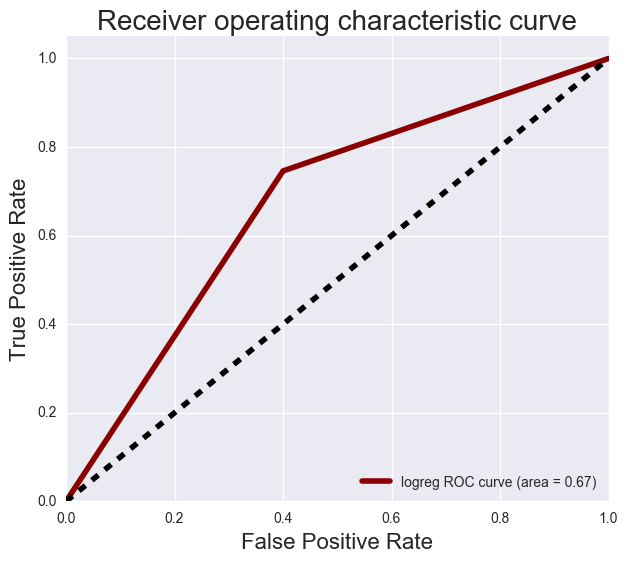

In [51]:
from sklearn.metrics import roc_curve, auc


# roc_curve returns the false positive rate and true positive rates as the threshold changes
# takes in the y and the predicted probabilities of the positive class from your model.
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred)
roc_auc_lr = auc(fpr_lr, tpr_lr)



plt.figure(figsize=[7,6])
plt.plot(fpr_lr, tpr_lr, label='logreg ROC curve (area = %0.2f)' % roc_auc_lr, 
         linewidth=4, color='darkred')
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic curve', fontsize=20)
plt.legend(loc="lower right")
plt.show()

The ROC curve confirms what the confusion matrix does: The Area (0.67) is greater than our baseline (0.5) which means overall this model predicts better than our baseline accuracy. 

#### Conclusions

In [55]:
X_train.columns[logistic_RFE_grid.best_estimator_.support_]

Index([       u'city_Boston',        u'city_Dallas',       u'city_Houston',
         u'city_Los+Angeles',         u'city_Miami',     u'city_Palo+Alto',
             u'city_Phoenix',    u'city_Pittsburgh',      u'city_Portland',
       u'city_San+Francisco',  u'summary_analytics',   u'summary_research',
           u'summary_senior',         u'title_data',       u'title_senior'],
      dtype='object')

In [56]:
len(X_train.columns[logistic_RFE_grid.best_estimator_.support_])

15

As stated before, the model predicted our test set with about 68% accuracy, greater than our baseline.  This was further validated through looking at both the confusion matrix and ROC curve. Furthermore, the optimal logistic regression model had 15 features (instead of the 33 kept). The best predictors (not in order are) if the job is in Boston, Dallas, Houston, Los Angeles, Miami, Palo Alto, Phoenix, Pittsburg, Portland or San Fransisco. In terms of the summary features, if the summary had the words analytics, research, or senior (or a combination of the 3) it proved to be a strong predictor. Finally, if the listing had in the title, data, senior or a combination of the both, it was a strong predictor if it was a good job or not. 

With more data, I think It would be pretty easy to get a much more accurate model, this is what should be focused on for future work.